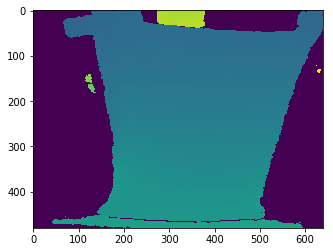

9324 0
255 255


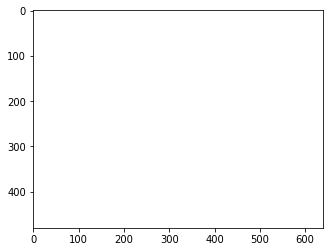

In [13]:
import cv2
import matplotlib.pyplot as plt
fn1 = "/home/rmqlife/work/result/depth0126/frm0.ppm"
fn2 = "/home/rmqlife/work/transform/data/2018-01-19-00-29-15/depth/0001.png"
im = cv2.imread(fn2, cv2.IMREAD_UNCHANGED)
plt.imshow(im)
plt.show()

import numpy as np
print(np.max(im), np.min(im))
im = cv2.imread(fn1, cv2.IMREAD_UNCHANGED)
print(np.max(im), np.min(im))
plt.imshow(im)
plt.show()

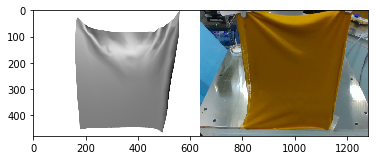

In [29]:
home1 = "/home/rmqlife/work/result/lights2/"
home2 = "/home/rmqlife/work/transform/data/2018-01-19-00-29-15/rgb/"
home3 = "/home/rmqlife/work/result/cat1"
home31 = "/home/rmqlife/work/result/cat1-1"
home32 = "/home/rmqlife/work/result/cat1-2"

from util import *
import os
for i in [home3,home31,home32]:
    if not os.path.exists(i):
        os.mkdir(i)
pics1 = get_filelist(home1)
pics1 = sorted(pics1,key=lambda x: int(os.path.basename(x)[:-4]))
pics2 = get_filelist(home2)
count = 0
for i in range(len(pics1)):
    im1 = cv2.imread(pics1[i])
    im2 = cv2.imread(pics2[i*5])
    im3 = np.concatenate((im1, im2), axis=1)
    cv2.imwrite(os.path.join(home3 + "/%04i.jpg" % count), im3)
    cv2.imwrite(os.path.join(home31 + "/%04i.jpg" % count), im1)
    cv2.imwrite(os.path.join(home32 + "/%04i.jpg" % count), im2)
    count+=1
plt.imshow(im3)
plt.show()

In [34]:
from util import *
import wrinkle2
import cv2
import numpy as np

def stack_vector(mat,vec):
    mat = np.vstack((mat,vec)) if mat.size else vec
    return mat

interval = 5

home = '/home/rmqlife/work/result/trans/'
rgblist1 = get_filelist('/home/rmqlife/work/result/trans/1/')
rgblist2 = get_filelist('/home/rmqlife/work/result/trans/2/')

tt_feat1 = np.array([])
tt_feat2 = np.array([])
tt_pos = np.array([])
robot_pos = np.load(home+'robot_pos.npy')
print("robot_pos loaded",robot_pos.shape)
print("images loaded", len(rgblist1),len(rgblist2))
for i in range(len(rgblist1)):
    print(rgblist1[i],rgblist2[i])
    im1 = cv2.imread(rgblist1[i], cv2.IMREAD_GRAYSCALE)
    im2 = cv2.imread(rgblist2[i], cv2.IMREAD_GRAYSCALE)
    feat1 = wrinkle2.howhist(im1)
    feat2 = wrinkle2.howhist(im2)
    pos = robot_pos[interval*i][:]
    tt_feat1 = stack_vector(tt_feat1,feat1)
    tt_feat2 = stack_vector(tt_feat2,feat2)
    tt_pos = stack_vector(tt_pos,pos)
    print(tt_feat1.shape,tt_feat2.shape,tt_pos.shape)
np.savez(home+'data',pos = tt_pos, feat1=tt_feat1, feat2=tt_feat2)

robot_pos loaded (2825, 6)
images loaded 565 565
/home/rmqlife/work/result/trans/1/0000.jpg /home/rmqlife/work/result/trans/2/0000.jpg
(192,) (192,) (6,)
/home/rmqlife/work/result/trans/1/0001.jpg /home/rmqlife/work/result/trans/2/0001.jpg
(2, 192) (2, 192) (2, 6)
/home/rmqlife/work/result/trans/1/0002.jpg /home/rmqlife/work/result/trans/2/0002.jpg
(3, 192) (3, 192) (3, 6)
/home/rmqlife/work/result/trans/1/0003.jpg /home/rmqlife/work/result/trans/2/0003.jpg
(4, 192) (4, 192) (4, 6)
/home/rmqlife/work/result/trans/1/0004.jpg /home/rmqlife/work/result/trans/2/0004.jpg
(5, 192) (5, 192) (5, 6)
/home/rmqlife/work/result/trans/1/0005.jpg /home/rmqlife/work/result/trans/2/0005.jpg
(6, 192) (6, 192) (6, 6)
/home/rmqlife/work/result/trans/1/0006.jpg /home/rmqlife/work/result/trans/2/0006.jpg
(7, 192) (7, 192) (7, 6)
/home/rmqlife/work/result/trans/1/0007.jpg /home/rmqlife/work/result/trans/2/0007.jpg
(8, 192) (8, 192) (8, 6)
/home/rmqlife/work/result/trans/1/0008.jpg /home/rmqlife/work/result/

(73, 192) (73, 192) (73, 6)
/home/rmqlife/work/result/trans/1/0073.jpg /home/rmqlife/work/result/trans/2/0073.jpg
(74, 192) (74, 192) (74, 6)
/home/rmqlife/work/result/trans/1/0074.jpg /home/rmqlife/work/result/trans/2/0074.jpg
(75, 192) (75, 192) (75, 6)
/home/rmqlife/work/result/trans/1/0075.jpg /home/rmqlife/work/result/trans/2/0075.jpg
(76, 192) (76, 192) (76, 6)
/home/rmqlife/work/result/trans/1/0076.jpg /home/rmqlife/work/result/trans/2/0076.jpg
(77, 192) (77, 192) (77, 6)
/home/rmqlife/work/result/trans/1/0077.jpg /home/rmqlife/work/result/trans/2/0077.jpg
(78, 192) (78, 192) (78, 6)
/home/rmqlife/work/result/trans/1/0078.jpg /home/rmqlife/work/result/trans/2/0078.jpg
(79, 192) (79, 192) (79, 6)
/home/rmqlife/work/result/trans/1/0079.jpg /home/rmqlife/work/result/trans/2/0079.jpg
(80, 192) (80, 192) (80, 6)
/home/rmqlife/work/result/trans/1/0080.jpg /home/rmqlife/work/result/trans/2/0080.jpg
(81, 192) (81, 192) (81, 6)
/home/rmqlife/work/result/trans/1/0081.jpg /home/rmqlife/wor

(146, 192) (146, 192) (146, 6)
/home/rmqlife/work/result/trans/1/0146.jpg /home/rmqlife/work/result/trans/2/0146.jpg
(147, 192) (147, 192) (147, 6)
/home/rmqlife/work/result/trans/1/0147.jpg /home/rmqlife/work/result/trans/2/0147.jpg
(148, 192) (148, 192) (148, 6)
/home/rmqlife/work/result/trans/1/0148.jpg /home/rmqlife/work/result/trans/2/0148.jpg
(149, 192) (149, 192) (149, 6)
/home/rmqlife/work/result/trans/1/0149.jpg /home/rmqlife/work/result/trans/2/0149.jpg
(150, 192) (150, 192) (150, 6)
/home/rmqlife/work/result/trans/1/0150.jpg /home/rmqlife/work/result/trans/2/0150.jpg
(151, 192) (151, 192) (151, 6)
/home/rmqlife/work/result/trans/1/0151.jpg /home/rmqlife/work/result/trans/2/0151.jpg
(152, 192) (152, 192) (152, 6)
/home/rmqlife/work/result/trans/1/0152.jpg /home/rmqlife/work/result/trans/2/0152.jpg
(153, 192) (153, 192) (153, 6)
/home/rmqlife/work/result/trans/1/0153.jpg /home/rmqlife/work/result/trans/2/0153.jpg
(154, 192) (154, 192) (154, 6)
/home/rmqlife/work/result/trans/1

(217, 192) (217, 192) (217, 6)
/home/rmqlife/work/result/trans/1/0217.jpg /home/rmqlife/work/result/trans/2/0217.jpg
(218, 192) (218, 192) (218, 6)
/home/rmqlife/work/result/trans/1/0218.jpg /home/rmqlife/work/result/trans/2/0218.jpg
(219, 192) (219, 192) (219, 6)
/home/rmqlife/work/result/trans/1/0219.jpg /home/rmqlife/work/result/trans/2/0219.jpg
(220, 192) (220, 192) (220, 6)
/home/rmqlife/work/result/trans/1/0220.jpg /home/rmqlife/work/result/trans/2/0220.jpg
(221, 192) (221, 192) (221, 6)
/home/rmqlife/work/result/trans/1/0221.jpg /home/rmqlife/work/result/trans/2/0221.jpg
(222, 192) (222, 192) (222, 6)
/home/rmqlife/work/result/trans/1/0222.jpg /home/rmqlife/work/result/trans/2/0222.jpg
(223, 192) (223, 192) (223, 6)
/home/rmqlife/work/result/trans/1/0223.jpg /home/rmqlife/work/result/trans/2/0223.jpg
(224, 192) (224, 192) (224, 6)
/home/rmqlife/work/result/trans/1/0224.jpg /home/rmqlife/work/result/trans/2/0224.jpg
(225, 192) (225, 192) (225, 6)
/home/rmqlife/work/result/trans/1

(288, 192) (288, 192) (288, 6)
/home/rmqlife/work/result/trans/1/0288.jpg /home/rmqlife/work/result/trans/2/0288.jpg
(289, 192) (289, 192) (289, 6)
/home/rmqlife/work/result/trans/1/0289.jpg /home/rmqlife/work/result/trans/2/0289.jpg
(290, 192) (290, 192) (290, 6)
/home/rmqlife/work/result/trans/1/0290.jpg /home/rmqlife/work/result/trans/2/0290.jpg
(291, 192) (291, 192) (291, 6)
/home/rmqlife/work/result/trans/1/0291.jpg /home/rmqlife/work/result/trans/2/0291.jpg
(292, 192) (292, 192) (292, 6)
/home/rmqlife/work/result/trans/1/0292.jpg /home/rmqlife/work/result/trans/2/0292.jpg
(293, 192) (293, 192) (293, 6)
/home/rmqlife/work/result/trans/1/0293.jpg /home/rmqlife/work/result/trans/2/0293.jpg
(294, 192) (294, 192) (294, 6)
/home/rmqlife/work/result/trans/1/0294.jpg /home/rmqlife/work/result/trans/2/0294.jpg
(295, 192) (295, 192) (295, 6)
/home/rmqlife/work/result/trans/1/0295.jpg /home/rmqlife/work/result/trans/2/0295.jpg
(296, 192) (296, 192) (296, 6)
/home/rmqlife/work/result/trans/1

(360, 192) (360, 192) (360, 6)
/home/rmqlife/work/result/trans/1/0360.jpg /home/rmqlife/work/result/trans/2/0360.jpg
(361, 192) (361, 192) (361, 6)
/home/rmqlife/work/result/trans/1/0361.jpg /home/rmqlife/work/result/trans/2/0361.jpg
(362, 192) (362, 192) (362, 6)
/home/rmqlife/work/result/trans/1/0362.jpg /home/rmqlife/work/result/trans/2/0362.jpg
(363, 192) (363, 192) (363, 6)
/home/rmqlife/work/result/trans/1/0363.jpg /home/rmqlife/work/result/trans/2/0363.jpg
(364, 192) (364, 192) (364, 6)
/home/rmqlife/work/result/trans/1/0364.jpg /home/rmqlife/work/result/trans/2/0364.jpg
(365, 192) (365, 192) (365, 6)
/home/rmqlife/work/result/trans/1/0365.jpg /home/rmqlife/work/result/trans/2/0365.jpg
(366, 192) (366, 192) (366, 6)
/home/rmqlife/work/result/trans/1/0366.jpg /home/rmqlife/work/result/trans/2/0366.jpg
(367, 192) (367, 192) (367, 6)
/home/rmqlife/work/result/trans/1/0367.jpg /home/rmqlife/work/result/trans/2/0367.jpg
(368, 192) (368, 192) (368, 6)
/home/rmqlife/work/result/trans/1

(432, 192) (432, 192) (432, 6)
/home/rmqlife/work/result/trans/1/0432.jpg /home/rmqlife/work/result/trans/2/0432.jpg
(433, 192) (433, 192) (433, 6)
/home/rmqlife/work/result/trans/1/0433.jpg /home/rmqlife/work/result/trans/2/0433.jpg
(434, 192) (434, 192) (434, 6)
/home/rmqlife/work/result/trans/1/0434.jpg /home/rmqlife/work/result/trans/2/0434.jpg
(435, 192) (435, 192) (435, 6)
/home/rmqlife/work/result/trans/1/0435.jpg /home/rmqlife/work/result/trans/2/0435.jpg
(436, 192) (436, 192) (436, 6)
/home/rmqlife/work/result/trans/1/0436.jpg /home/rmqlife/work/result/trans/2/0436.jpg
(437, 192) (437, 192) (437, 6)
/home/rmqlife/work/result/trans/1/0437.jpg /home/rmqlife/work/result/trans/2/0437.jpg
(438, 192) (438, 192) (438, 6)
/home/rmqlife/work/result/trans/1/0438.jpg /home/rmqlife/work/result/trans/2/0438.jpg
(439, 192) (439, 192) (439, 6)
/home/rmqlife/work/result/trans/1/0439.jpg /home/rmqlife/work/result/trans/2/0439.jpg
(440, 192) (440, 192) (440, 6)
/home/rmqlife/work/result/trans/1

(504, 192) (504, 192) (504, 6)
/home/rmqlife/work/result/trans/1/0504.jpg /home/rmqlife/work/result/trans/2/0504.jpg
(505, 192) (505, 192) (505, 6)
/home/rmqlife/work/result/trans/1/0505.jpg /home/rmqlife/work/result/trans/2/0505.jpg
(506, 192) (506, 192) (506, 6)
/home/rmqlife/work/result/trans/1/0506.jpg /home/rmqlife/work/result/trans/2/0506.jpg
(507, 192) (507, 192) (507, 6)
/home/rmqlife/work/result/trans/1/0507.jpg /home/rmqlife/work/result/trans/2/0507.jpg
(508, 192) (508, 192) (508, 6)
/home/rmqlife/work/result/trans/1/0508.jpg /home/rmqlife/work/result/trans/2/0508.jpg
(509, 192) (509, 192) (509, 6)
/home/rmqlife/work/result/trans/1/0509.jpg /home/rmqlife/work/result/trans/2/0509.jpg
(510, 192) (510, 192) (510, 6)
/home/rmqlife/work/result/trans/1/0510.jpg /home/rmqlife/work/result/trans/2/0510.jpg
(511, 192) (511, 192) (511, 6)
/home/rmqlife/work/result/trans/1/0511.jpg /home/rmqlife/work/result/trans/2/0511.jpg
(512, 192) (512, 192) (512, 6)
/home/rmqlife/work/result/trans/1

train_size 452
67
(67, 192) (67, 6)
data shape (565, 6) (565, 192)
data_size 565 565


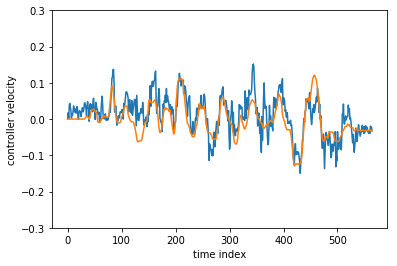

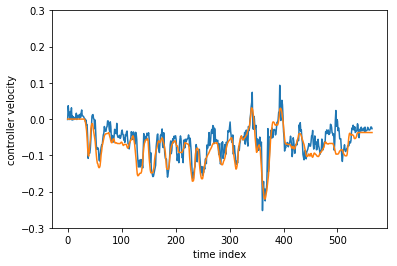

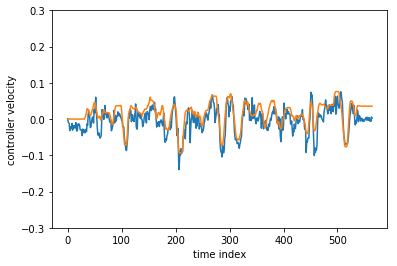

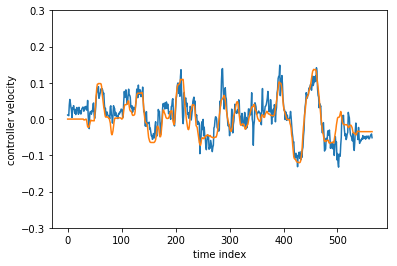

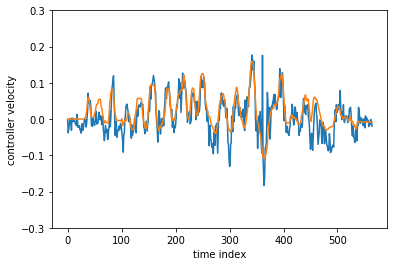

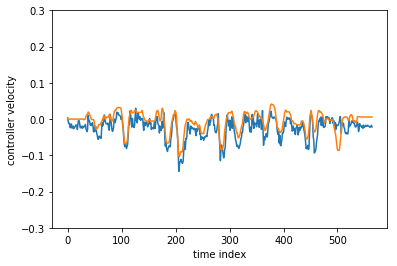

In [43]:
#regression
import os, cv2
import matplotlib.pyplot as plt
from regression import *

data_name = '/home/rmqlife/work/result/trans/data.npz'

data = np.load(data_name)
pos = data['pos']
feat = data['feat1']

prop = 0.8
train_size = int(len(pos)*prop)
print("train_size", train_size)

model = load_model_data(pos[:train_size], feat[:train_size], num_samples=0.3, alpha=1e-4)
print('data shape', pos.shape,feat.shape)
# Use the model to predict the velocity/direction of end effector
target = 0  # target index  
X = feat - feat[target]
y = pos - pos[target]
y_pred = model.predict(X)

print("data_size", len(y), len(y_pred))
for i in range(y_pred.shape[1]):
    axes = plt.gca()
    axes.set_xlabel('time index')
    axes.set_ylabel('controller velocity')
    axes.set_ylim([-0.3,0.3])
    plt.plot(range(y_pred.shape[0]),y_pred[:,i], label = 'predicted')
    plt.plot(range(y.shape[0]),y[:,i], label = 'ground truth')
    plt.show()